# Load checkpoint and imports

In [1]:
import sys
import warnings

import pandas as pd

warnings.filterwarnings('ignore') 
parent_dir = "/Midgard/home/farzantn/phd/Olfaction/MoLFormer_N2024"
# parent_dir="/Volumes/work/phd/MoLFormer_N2024"
sys.path.append(parent_dir)
# parent_dir="/Midgard/home/farzantn/mambaforge/envs/MolTran_CUDA11_cuda/lib/python3.8"
# sys.path.append(parent_dir)

In [2]:
import pandas as pd
from utils.util_alignment import set_seeds
from utils.visualization_helper import *  
import matplotlib.pyplot as plt
from sklearn.metrics import cohen_kappa_score
import pingouin as pg
from constants import *
from sklearn.metrics import roc_auc_score,mean_squared_error,mean_squared_error

Skipped loading some Tensorflow models, missing a dependency. No module named 'tensorflow'
Skipped loading modules with pytorch-geometric dependency, missing a dependency. No module named 'torch_geometric'
Skipped loading modules with pytorch-geometric dependency, missing a dependency. cannot import name 'DMPNN' from 'deepchem.models.torch_models' (/Midgard/home/farzantn/mambaforge/envs/Mol/lib/python3.8/site-packages/deepchem/models/torch_models/__init__.py)
Skipped loading some Jax models, missing a dependency. No module named 'jax'


Mol


In [3]:
base_path= '/local_storage/datasets/farzaneh/alignment_olfaction_datasets/'
# base_path= '../../../../T5 EVO/alignment_olfaction_datasets/'
results_path = 'curated_datasets/dfs_result/regression/'

In [4]:
seed = 2024
set_seeds(seed)

In [5]:
times=30
n_components=20

# Helper Methods

In [6]:
def normalize_rmse(df,min_max,j):
    max_values = min_max.max()
    min_values = min_max.min()
    min_max.columns = ['Dataset','Type']+df.columns.values.tolist()[:j]
    # Drop 'Dataset' and 'Type' as they are not numeric columns
    min_values = min_values.drop(['Dataset', 'Type'])
    max_values = max_values.drop(['Dataset', 'Type'])
    for i,col in enumerate(df.columns[:j]):
        df[col] = np.sqrt(df[col]) / (max_values[i] - min_values[i])
    return df

In [7]:
def proccess_df_for_ICC(csv_results,ds='keller',layer=13):
    
    if ds=='keller':
        tasks = keller_tasks
    elif ds=='sagar':
        tasks = sagar_tasks
    else:
        raise ValueError('Dataset not found')
    
    df=pd.read_csv(base_path+results_path+csv_results)
    df = df[df['layer'] == layer]
    columns_predicted = [task+'_predicted' for task in tasks]
    columns_true= [task+'_true' for task in tasks]
    df = df.drop_duplicates(subset=['model','CID'],inplace=False)
    df_predictions = df[['model','CID']+columns_predicted]
    df_true = df[['model','CID']+columns_true]
    df_melted_predicted = pd.melt(df_predictions, id_vars=['model','CID'], value_vars=columns_predicted)
    df_melted_true = pd.melt(df_true, id_vars=['model','CID'], value_vars=columns_true)
    df_melted_true['model'] = 'subjects_average' 
    df_concatenated = pd.concat([df_melted_predicted, df_melted_true], axis=0)
    df_concatenated['variable'] = df_concatenated['variable'].str.split('_', expand=True)[0]
    return df_concatenated

In [8]:
def proccess_df_for_Cor(csv_results,ds='keller',layer=13):

    if ds=='keller':
        tasks = keller_tasks
    elif ds=='sagar':
        tasks = sagar_tasks
    else:
        raise ValueError('Dataset not found')

    df=pd.read_csv(base_path+results_path+csv_results)
    df = df[df['layer'] == layer]
    columns_predicted = [task+'_predicted' for task in tasks]
    columns_true= [task+'_true' for task in tasks]
    df = df.drop_duplicates(subset=['model','CID'],inplace=False)
    df_predictions = df[['model','CID']+columns_predicted]
    df_true = df[['model','CID']+columns_true]
    df_melted_predicted = pd.melt(df_predictions, id_vars=['model','CID'], value_vars=[columns_predicted,columns_true])
    df_melted_true = pd.melt(df_true, id_vars=['model','CID'], value_vars=columns_true)
    df_melted_true['model'] = 'subjects_average'
    df_concatenated = pd.concat([df_melted_predicted, df_melted_true], axis=0)
    df_concatenated['variable'] = df_concatenated['variable'].str.split('_', expand=True)[0]
    return df_concatenated

In [9]:
# def proccess_df_for_nrmse(csv_results,ds='keller',layer=13):
#     
#     if ds=='keller':
#         tasks = keller_tasks
#     elif ds=='sagar':
#         tasks = sagar_tasks
#     else:
#         raise ValueError('Dataset not found')
#     
#     df=pd.read_csv(base_path+results_path+csv_results)
#     df = df[df['layer'] == layer]
#     columns_predicted = [task+'_predicted' for task in tasks]
#     columns_true= [task+'_true' for task in tasks]
#     df = df.drop_duplicates(subset=['model','CID'],inplace=False)
#     df_predictions = df[['model','CID']+columns_predicted]
#     df_true = df[['model','CID']+columns_true]
#     df_melted_predicted = pd.melt(df_predictions, id_vars=['model','CID'], value_vars=columns_predicted)
#     df_melted_true = pd.melt(df_true, id_vars=['model','CID'], value_vars=columns_true)
#     df_melted_true['model'] = 'subjects_average' 
#     df_concatenated = pd.concat([df_melted_predicted, df_melted_true], axis=0)
#     df_concatenated['variable'] = df_concatenated['variable'].str.split('_', expand=True)[0]
#     return df_concatenated

In [10]:
def compute_ICC_mvm_permolecul_avgsubj(df_concatenated,model_list,model1='molformer'):
    results_dict = {}
    # model2_list = ["subject_"+str(i) for i in range(1,56)]+['subjects_average']
    for model2 in model_list:
        df_concatenated_model = df_concatenated[(df_concatenated['model']==model1) | (df_concatenated['model']==model2)]
        grouped = df_concatenated_model.groupby('variable')
        results_dict[model2] = {}

        for variable, group in grouped:
            group = group.drop('variable',axis=1)
            inte_class_corr = pg.intraclass_corr(data=group, targets='CID', raters='model',ratings='value', nan_policy='omit')
            print(variable, inte_class_corr)
            inte_class_corr['variable'] = variable
            inte_class_corr['model_2'] = model2
            results_dict[model2][variable] = inte_class_corr
            
            #save result in a dictioney with model ad variable as key
        
        
    rows = []
    for model, variables in results_dict.items():
        row = {'model_2': model}
        for variable, result in variables.items():
            row[variable] = result[result['Type'] == 'ICC3']['ICC'].values[0]
        rows.append(row)
    df_results = pd.DataFrame(rows)
            
            
            # dfs.append(inte_class_corr)            
    return df_results


In [11]:
def compute_correlation_mvm_permolecul_avgsubj(df_concatenated,model_list,model1='molformer'):
    results_dict = {}
    # model2_list = ["subject_"+str(i) for i in range(1,56)]+['subjects_average']
    for model2 in model_list:
        df_concatenated_model = df_concatenated[(df_concatenated['model']==model1) | (df_concatenated['model']==model2)]
        grouped = df_concatenated_model.groupby('variable')
        results_dict[model2] = {}

        for variable, group in grouped:
            group = group.drop('variable',axis=1)
            inte_class_corr = mean_squared_error(data=group, targets='CID', raters='model',ratings='value', nan_policy='omit')
            print(variable, inte_class_corr)
            inte_class_corr['variable'] = variable
            inte_class_corr['model_2'] = model2
            results_dict[model2][variable] = inte_class_corr

            #save result in a dictioney with model ad variable as key


    rows = []
    for model, variables in results_dict.items():
        row = {'model_2': model}
        for variable, result in variables.items():
            row[variable] = result[result['Type'] == 'ICC3']['ICC'].values[0]
        rows.append(row)
    df_results = pd.DataFrame(rows)


            # dfs.append(inte_class_corr)
    return df_results


In [12]:
def plot_miguel_favorite(df_melted_true,df_melted_predicted):
    plt.figure(figsize=(80, 80))
    plt.xticks(rotation=90)
    sns.boxplot(x='variable', y='value', hue='model', data=df_melted_predicted, showfliers=False)
    
    # Plot fliers using df_melted_true
    # sns.scatterplot(x='variable', y='value', data=df_melted_true, alpha=0.5)
    for i, category in enumerate(df_melted_true['variable'].unique()):
        category_fliers = df_melted_true[df_melted_true['variable'] == category]
        # category_fliers['value'] = abs(category_fliers['value'])
        x_positions = [i] * len(category_fliers)
        sns.scatterplot(x=x_positions, y=category_fliers['value'], color='red', s=150, marker='o')
    
    # Display the plot
    plt.show()

In [13]:
def visualoze_violinplot(df_results_all,ds,title):
    if ds=='keller':
        tasks = keller_tasks
    elif ds=='sagar':
        tasks = sagar_tasks
    else:
        raise ValueError('Dataset not found')
    
    df_results_all_melt = pd.melt(df_results_all, id_vars=['model_1', 'model_2'], value_vars=tasks, var_name='variable', value_name='ICC')
    df_results_all_melt_pom = df_results_all_melt[df_results_all_melt['model_2']=='pom']
    df_results_all_melt_molformer = df_results_all_melt[df_results_all_melt['model_2']=='molformer']
    df_results_all_melt_dam = df_results_all_melt[df_results_all_melt['model_2']=='alva']
    # df_results_all_melt_subjects_average = df_results_all_melt[df_results_all_melt['model_2']=='subjects_average']
    df_results_all_melt_tov = df_results_all_melt[~df_results_all_melt['model_2'].isin(['subjects_average','molformer','pom','alva'])]
    
    
    plt.rcParams["font.size"] = 40
    f = plt.figure(figsize=(30, 20))
    g = sns.violinplot(data=df_results_all_melt_tov, x="variable", y=title,color="#d7f1f7",linewidth=2)
    g.set_xticklabels(tasks, rotation=90,size=40)
    g.set_xlabel('Descriptor', fontsize=40)
    g.set_ylabel(title, fontsize=40)
    plt.xticks(fontsize=40, rotation=90)
    plt.yticks(fontsize=40)
    
    
    # sns.boxplot(x='variable', y='value', hue='model', data=df_melted_predicted, showfliers=False)
    
    # Plot fliers using df_melted_true
    # sns.scatterplot(x='variable', y='value', data=df_melted_true, alpha=0.5)
    for i, category in enumerate(df_results_all_melt_molformer['variable'].unique()):
        category_fliers_molformer = df_results_all_melt_molformer[df_results_all_melt_molformer['variable'] == category]
        category_fliers_pom = df_results_all_melt_pom[df_results_all_melt_pom['variable'] == category]
        category_fliers_dam = df_results_all_melt_dam[df_results_all_melt_dam['variable'] == category]
        # category_fliers_subjects_average = df_results_all_melt_subjects_average[df_results_all_melt_subjects_average['variable'] == category]
        x_positions = [i] * len(category_fliers_molformer)
        
        # '#4d79a4', '#ecc947', '#b07aa0'
        
        category_fliers = pd.concat([category_fliers_molformer,category_fliers_pom,category_fliers_dam],axis=0)
        
        x_positions_all  = x_positions*3
        # print(x_positions_all,category_fliers,"sss")
       
        # sns.scatterplot(x=x_positions, y=category_fliers_molformer['ICC'], color='#4d79a4', s=1200, marker='o',label='MoLFormer')
        # sns.scatterplot(x=x_positions, y=category_fliers_pom['ICC'], color='#ecc947', s=1200, marker='o',label='Open-POM')
        # sns.scatterplot(x=x_positions, y=category_fliers_dam['ICC'], color='#b07aa0', s=1200, marker='o',label='DAM')
        colors = ['#4d79a4','#ecc947','#b07aa0','#eb4034']
        print("ssssssmmmm",x_positions_all,category_fliers)
        g = sns.scatterplot(x=x_positions_all, y=category_fliers[title],hue=category_fliers['model_2'], palette=colors , s=500, marker='o')
        
        
        g.legend().set_title("Model")
    # handles, labels = g1.get_legend_handles_labels()
        handles, labels = g.get_legend_handles_labels()
        g.get_legend().remove()
        # print(labels)
        
        labels = ['MoLFormer', 'Open-POM', 'DAM', 'Subjects Average']
        plt.rcParams["font.size"] = 40
    
        f.legend(handles, labels, ncol=4, columnspacing=1, prop={'size': 40}, handlelength=1.5, loc="lower center",
              borderpad=0.3,
              bbox_to_anchor=(0.52, -0.2),
              frameon=True, labelspacing=0.4, handletextpad=0.2, )
        
        # print(i, x_positions,category_fliers_molformer[title],"ssssss")
        # g = sns.scatterplot(x=x_positions, y=category_fliers_subjects_average[title], color="red" , s=500, marker='_')

    
    # Display the plot
    # plt.show()
    plt.savefig('figs/'+ds + "_"+title + "_violinplott.pdf", bbox_inches='tight')
    
    

# Extracting Representations

## Keller

In [14]:
input_file_keller = base_path+'curated_datasets/mols_datasets/curated_keller2016_nona.csv' # or new downloaded file path
df_keller_temp=pd.read_csv(input_file_keller)

In [22]:
df_keller_cor_pom=pd.read_csv(base_path+results_path+"df_keller_cor_pom.csv")
df_keller_mse_pom=pd.read_csv(base_path+results_path+"df_keller_mse_pom.csv")
df_keller_cor_alva=pd.read_csv(base_path+results_path+"df_keller_cor_alva.csv")
df_keller_mse_alva=pd.read_csv(base_path+results_path+"df_keller_mse_alva.csv")
df_keller_corrs_molfomer=pd.read_csv(base_path+results_path+"df_keller_corrs_molfomer.csv")
df_keller_mses_molfomer=pd.read_csv(base_path+results_path+"df_keller_mses_molfomer.csv")
df_keller_corrs_molfomerfinetuned=pd.read_csv(base_path+results_path+"df_keller_corrs_molfomerfinetuned.csv")
df_keller_mses_molfomerfinetuned=pd.read_csv(base_path+results_path+"df_keller_mses_molfomerfinetuned.csv")

In [23]:
min_max_keller = pd.read_csv(base_path+results_path+"keller_min_max.csv")
df_keller_mse_pom=normalize_rmse(df_keller_mse_pom,min_max_keller,j=-1)
df_keller_mse_alva=normalize_rmse(df_keller_mse_alva,min_max_keller,j=-1)
df_keller_mses_molfomer=normalize_rmse(df_keller_mses_molfomer,min_max_keller,j=-2)
df_keller_mses_molfomerfinetuned=normalize_rmse(df_keller_mses_molfomerfinetuned,min_max_keller,j=-2)

['molformer', 'molformerfinetuned', 'pom', 'alva']


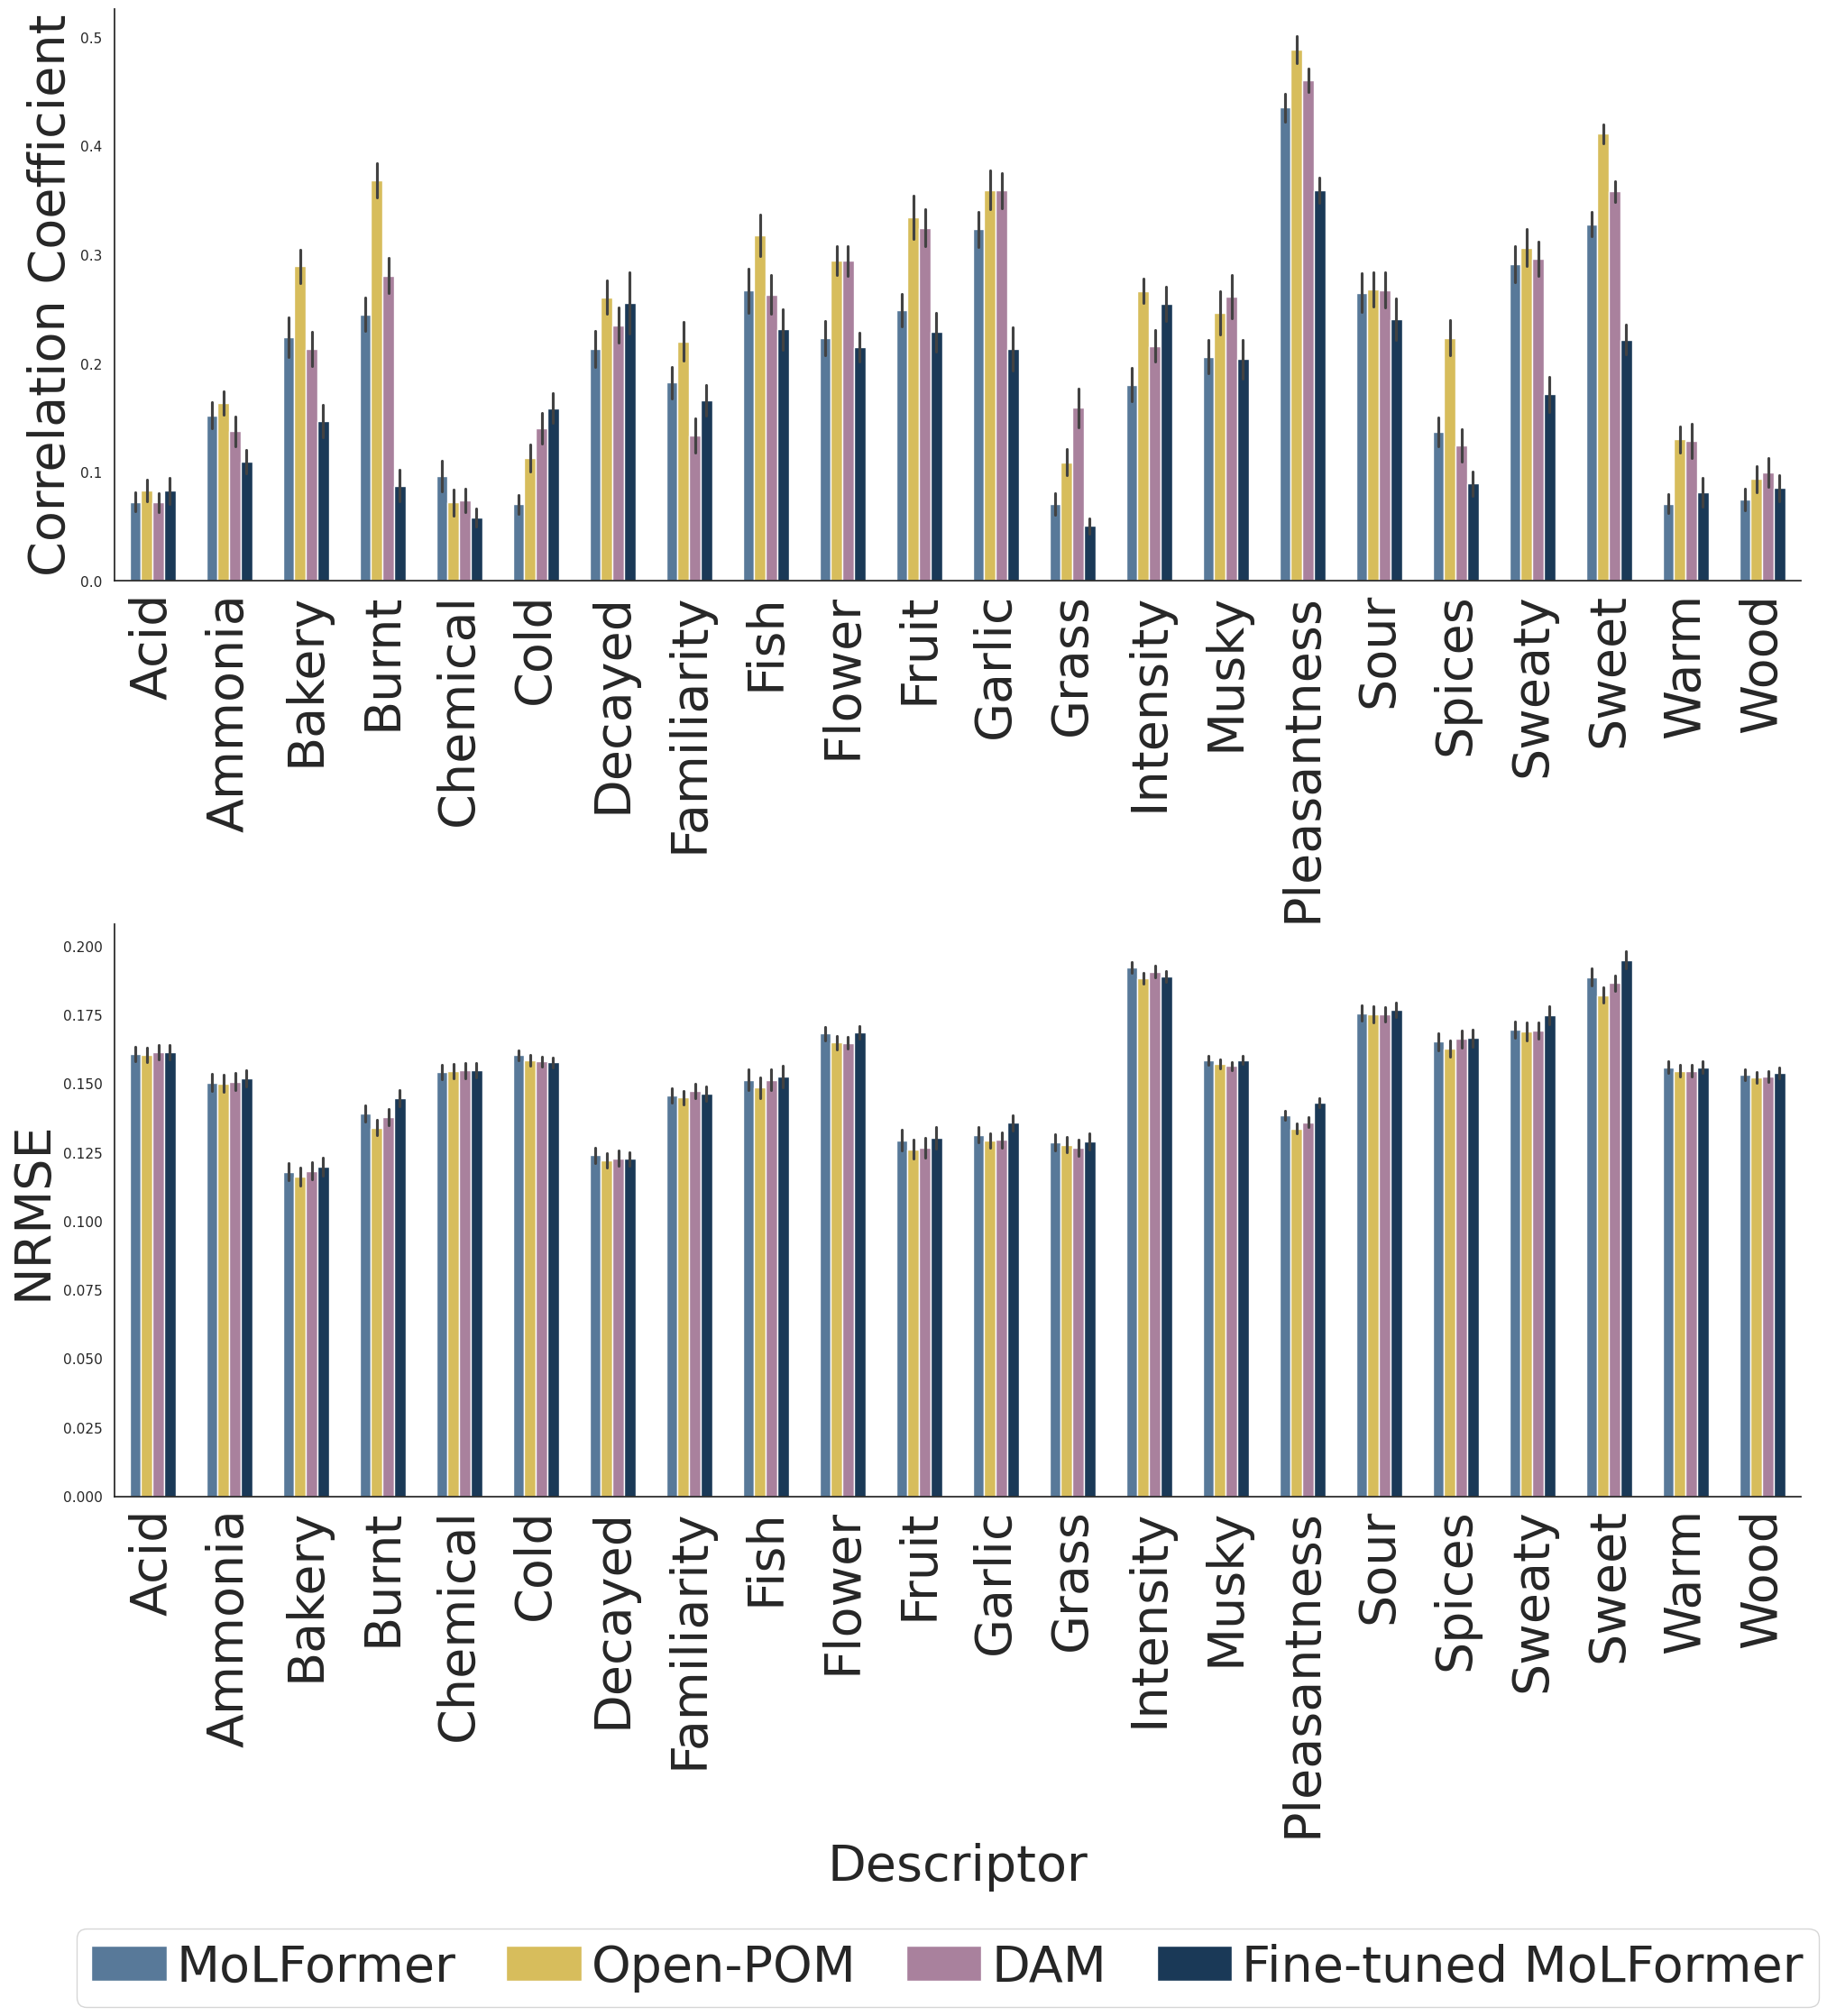

In [24]:
trend_learning_molformer =  post_process_dataframe(df_keller_corrs_molfomer,df_keller_mses_molfomer,df_keller_corrs_molfomerfinetuned,df_keller_mses_molfomerfinetuned,df_keller_cor_pom,df_keller_cor_alva,df_keller_mse_pom,df_keller_mse_alva,keller_tasks,"figs/keller_regression")
# trend_learning_molformer['dataset']='keller'

In [25]:
df_concatenated_keller = proccess_df_for_ICC("keller_predictions.csv", ds='keller',layer=13)
df_keller_temp = df_keller_temp.rename(columns={'Subject': 'model'})
df_keller_subjects = df_keller_temp.melt(id_vars=['model', 'CID'], value_vars=keller_tasks, var_name='variable', value_name='value')
df_keller_subjects['model'] = df_keller_subjects['model'].apply(lambda x: 'subject_' + str(x))
df_keller_all = pd.concat([df_concatenated_keller, df_keller_subjects], axis=0)
model_list = ["subject_"+str(i) for i in range(1,56)]+['molformer','pom','alva']


In [20]:
# import scipy
# df_concatenated_keller = proccess_df_for_Cor("keller_predictions.csv", ds='keller',layer=13)
# df_keller_temp = df_keller_temp.rename(columns={'Subject': 'model'})
# df_keller_subjects = df_keller_temp.melt(id_vars=['model', 'CID'], value_vars=keller_tasks, var_name='variable', value_name='value')
# df_keller_subjects['model'] = df_keller_subjects['model'].apply(lambda x: 'subject_' + str(x))
# df_keller_all = pd.concat([df_concatenated_keller, df_keller_subjects], axis=0)
# model_list = ["subject_"+str(i) for i in range(1,56)]+['molformer','pom','alva']
# 
# df_keller_all

# # df_keller = pd.read_csv(base_path+results_path+"keller_predictions.csv")
# #compute rmse for each pair of descriptor_true and descriptor_predicted
#
# # Assuming df is your DataFrame and true_cols and pred_cols are lists of your columns
# true_cols = [col for col in df_keller.columns if 'true' in col]
# pred_cols = [col for col in df_keller.columns if 'predicted' in col]
#
# rmse_results = {}
# # print(true_cols,pred_cols
# for true_col, pred_col in zip(true_cols, pred_cols):
#     df_keller[true_col.split('_')[0]+'_correlation'] =  scipy.stats.pearsonr(df_keller[true_col], df_keller[pred_col]).statistic

In [116]:
# df_keller

,CID,Acid_predicted,Ammonia_predicted,Bakery_predicted,Burnt_predicted,Chemical_predicted,Cold_predicted,Decayed_predicted,Familiarity_predicted,Fish_predicted,...,Grass_correlation,Intensity_correlation,Musky_correlation,Pleasantness_correlation,Sour_correlation,Spices_correlation,Sweaty_correlation,Sweet_correlation,Warm_correlation,Wood_correlation
0,1549026.0,3.322172,2.919522,1.955916,2.222589,8.299418,4.199796,2.311181,43.143029,1.219987,...,0.020861,0.180738,0.159002,0.403744,0.241621,0.125315,0.235868,0.296426,0.041749,-0.005674
1,24834.0,3.257202,3.035074,3.549364,4.148400,8.231839,3.110157,2.190521,45.386617,0.926214,...,0.020861,0.180738,0.159002,0.403744,0.241621,0.125315,0.235868,0.296426,0.041749,-0.005674
2,9261.0,2.930286,3.309826,4.374484,5.389800,8.140680,2.911365,4.072102,44.239540,1.602673,...,0.020861,0.180738,0.159002,0.403744,0.241621,0.125315,0.235868,0.296426,0.041749,-0.005674
3,13561.0,3.912280,2.696031,1.734145,3.388272,9.456075,3.796907,2.807965,41.754181,1.495437,...,0.020861,0.180738,0.159002,0.403744,0.241621,0.125315,0.235868,0.296426,0.041749,-0.005674
4,7092.0,3.020651,2.502595,3.802575,3.825581,9.057105,2.275114,1.648028,45.456044,0.695144,...,0.020861,0.180738,0.159002,0.403744,0.241621,0.125315,0.235868,0.296426,0.041749,-0.005674
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
43195,5363388.0,3.535321,2.689782,2.590685,3.384925,8.371863,3.619612,2.414457,43.817950,1.158803,...,0.020861,0.180738,0.159002,0.403744,0.241621,0.125315,0.235868,0.296426,0.041749,-0.005674
43196,8093.0,3.681522,3.162458,2.188024,3.308735,8.559688,3.168470,2.934242,42.812459,1.562121,...,0.020861,0.180738,0.159002,0.403744,0.241621,0.125315,0.235868,0.296426,0.041749,-0.005674
43197,2537.0,3.478860,3.126322,3.096516,3.911667,8.901791,3.289458,2.254937,45.254938,1.016524,...,0.020861,0.180738,0.159002,0.403744,0.241621,0.125315,0.235868,0.296426,0.041749,-0.005674
43198,6506.0,3.661014,2.782725,2.126523,3.257547,8.208871,3.547766,2.224639,42.522770,0.963493,...,0.020861,0.180738,0.159002,0.403744,0.241621,0.125315,0.235868,0.296426,0.041749,-0.005674


In [26]:
df_results_keller_all_antonio_faviorte = pd.DataFrame()
for model_1 in ['subjects_average']:
    df_results_keller = compute_ICC_mvm_permolecul_avgsubj(df_keller_all,model_list,model1=model_1)
    df_results_keller['model_1'] = model_1
    df_results_keller_all_antonio_faviorte = pd.concat([df_results_keller_all_antonio_faviorte,df_results_keller],axis=0)

Acid     Type              Description       ICC         F  df1  df2      pval  \
0   ICC1   Single raters absolute  0.100147  1.222584  299  300  0.041262   
1   ICC2     Single random raters  0.105703  1.239704  299  299  0.031840   
2   ICC3      Single fixed raters  0.107025  1.239704  299  299  0.031840   
3  ICC1k  Average raters absolute  0.182060  1.222584  299  300  0.041262   
4  ICC2k    Average random raters  0.191196  1.239704  299  299  0.031840   
5  ICC3k     Average fixed raters  0.193356  1.239704  299  299  0.031840   

           CI95%  
0  [-0.01, 0.21]  
1  [-0.01, 0.22]  
2  [-0.01, 0.22]  
3  [-0.03, 0.35]  
4  [-0.01, 0.35]  
5  [-0.01, 0.36]  
Ammonia     Type              Description       ICC         F  df1  df2      pval  \
0   ICC1   Single raters absolute -0.090510  0.834005  299  300  0.941575   
1   ICC2     Single random raters  0.022949  1.059687  299  299  0.308265   
2   ICC3      Single fixed raters  0.028979  1.059687  299  299  0.308265   
3  ICC

In [27]:
# df_results_keller_all_antonio_faviorte.model_2.unique()

ssssssmmmm [0, 0, 0]              model_1    model_2 variable       ICC
55  subjects_average  molformer     Acid  0.004023
56  subjects_average        pom     Acid -0.000491
57  subjects_average       alva     Acid -0.011806
ssssssmmmm [1, 1, 1]               model_1    model_2 variable       ICC
113  subjects_average  molformer  Ammonia  0.050208
114  subjects_average        pom  Ammonia  0.048511
115  subjects_average       alva  Ammonia  0.033887
ssssssmmmm [2, 2, 2]               model_1    model_2 variable       ICC
171  subjects_average  molformer   Bakery  0.070652
172  subjects_average        pom   Bakery  0.076727
173  subjects_average       alva   Bakery  0.057752
ssssssmmmm [3, 3, 3]               model_1    model_2 variable       ICC
229  subjects_average  molformer    Burnt  0.124891
230  subjects_average        pom    Burnt  0.138736
231  subjects_average       alva    Burnt  0.029733
ssssssmmmm [4, 4, 4]               model_1    model_2  variable       ICC
287  subjects_

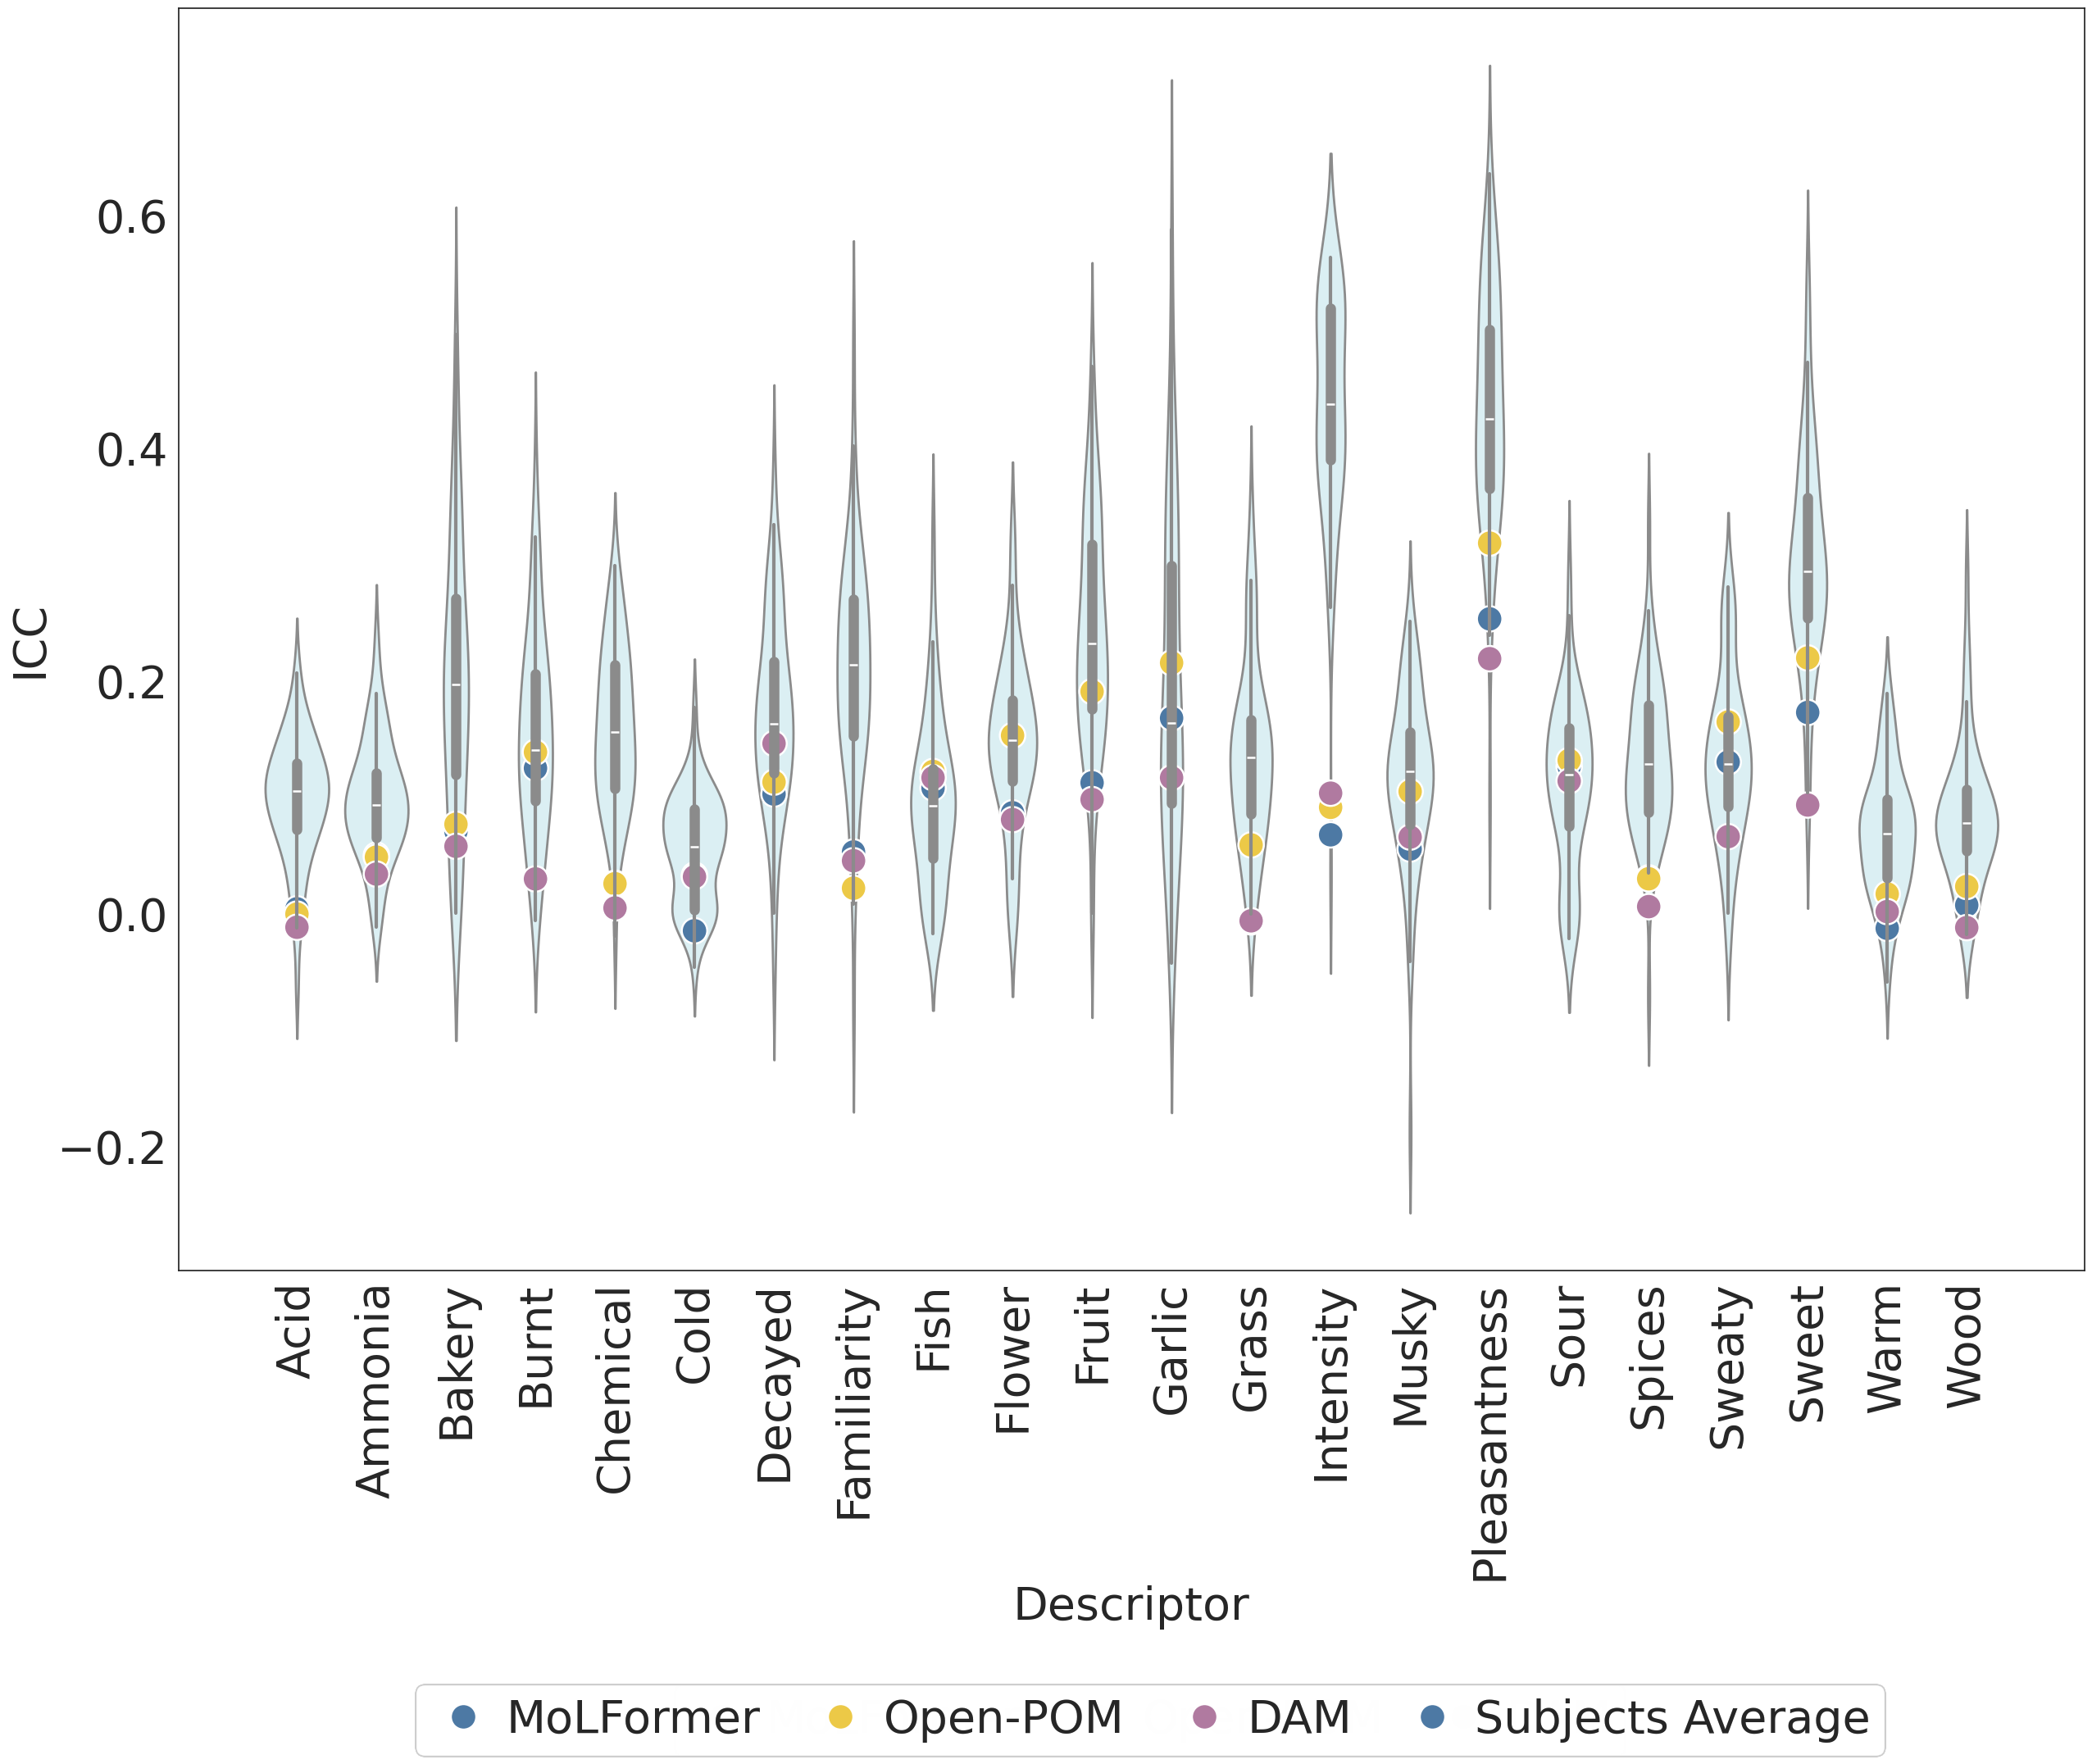

In [28]:
visualoze_violinplot(df_results_keller_all_antonio_faviorte,ds='keller',title='ICC')

In [29]:

input_file_sagar = base_path+'curated_datasets/mols_datasets/curated_sagar_subjects_nonaminus.csv' # or new downloaded fil
df_sagar_temp=pd.read_csv(input_file_sagar)

In [30]:
# corrs_molfomer,mses_molformer,df_keller_cor_pom,df_keller_mse_pom,df_keller_cor_alva,df_keller_mse_alva =compute_correlation_keller(times , n_components,per_descritor=False)
df_sagar_cor_pom=pd.read_csv(base_path+results_path+"df_sagar_cor_pom.csv")
df_sagar_mse_pom=pd.read_csv(base_path+results_path+"df_sagar_mse_pom.csv")
df_sagar_cor_alva=pd.read_csv(base_path+results_path+"df_sagar_cor_alva.csv")
df_sagar_mse_alva=pd.read_csv(base_path+results_path+"df_sagar_mse_alva.csv")
df_sagar_corrs_molfomer=pd.read_csv(base_path+results_path+"df_sagar_corrs_molfomer.csv")
df_sagar_mses_molfomer=pd.read_csv(base_path+results_path+"df_sagar_mses_molfomer.csv")
df_sagar_corrs_molfomerfinetuned=pd.read_csv(base_path+results_path+"df_sagar_corrs_molfomerfinetuned.csv")
df_sagar_mses_molfomerfinetuned=pd.read_csv(base_path+results_path+"df_sagar_mses_molfomerfinetuned.csv")


In [31]:
min_max_sagar = pd.read_csv(base_path+results_path+"sagar_min_max.csv")
df_sagar_mse_pom=normalize_rmse(df_sagar_mse_pom,min_max_sagar,j=-1)
df_sagar_mse_alva=normalize_rmse(df_sagar_mse_alva,min_max_sagar,j=-1)
df_sagar_mses_molfomer=normalize_rmse(df_sagar_mses_molfomer,min_max_sagar,j=-2)
df_sagar_mses_molfomerfinetuned=normalize_rmse(df_sagar_mses_molfomerfinetuned,min_max_sagar,j=-2)


['molformer', 'molformerfinetuned', 'pom', 'alva']


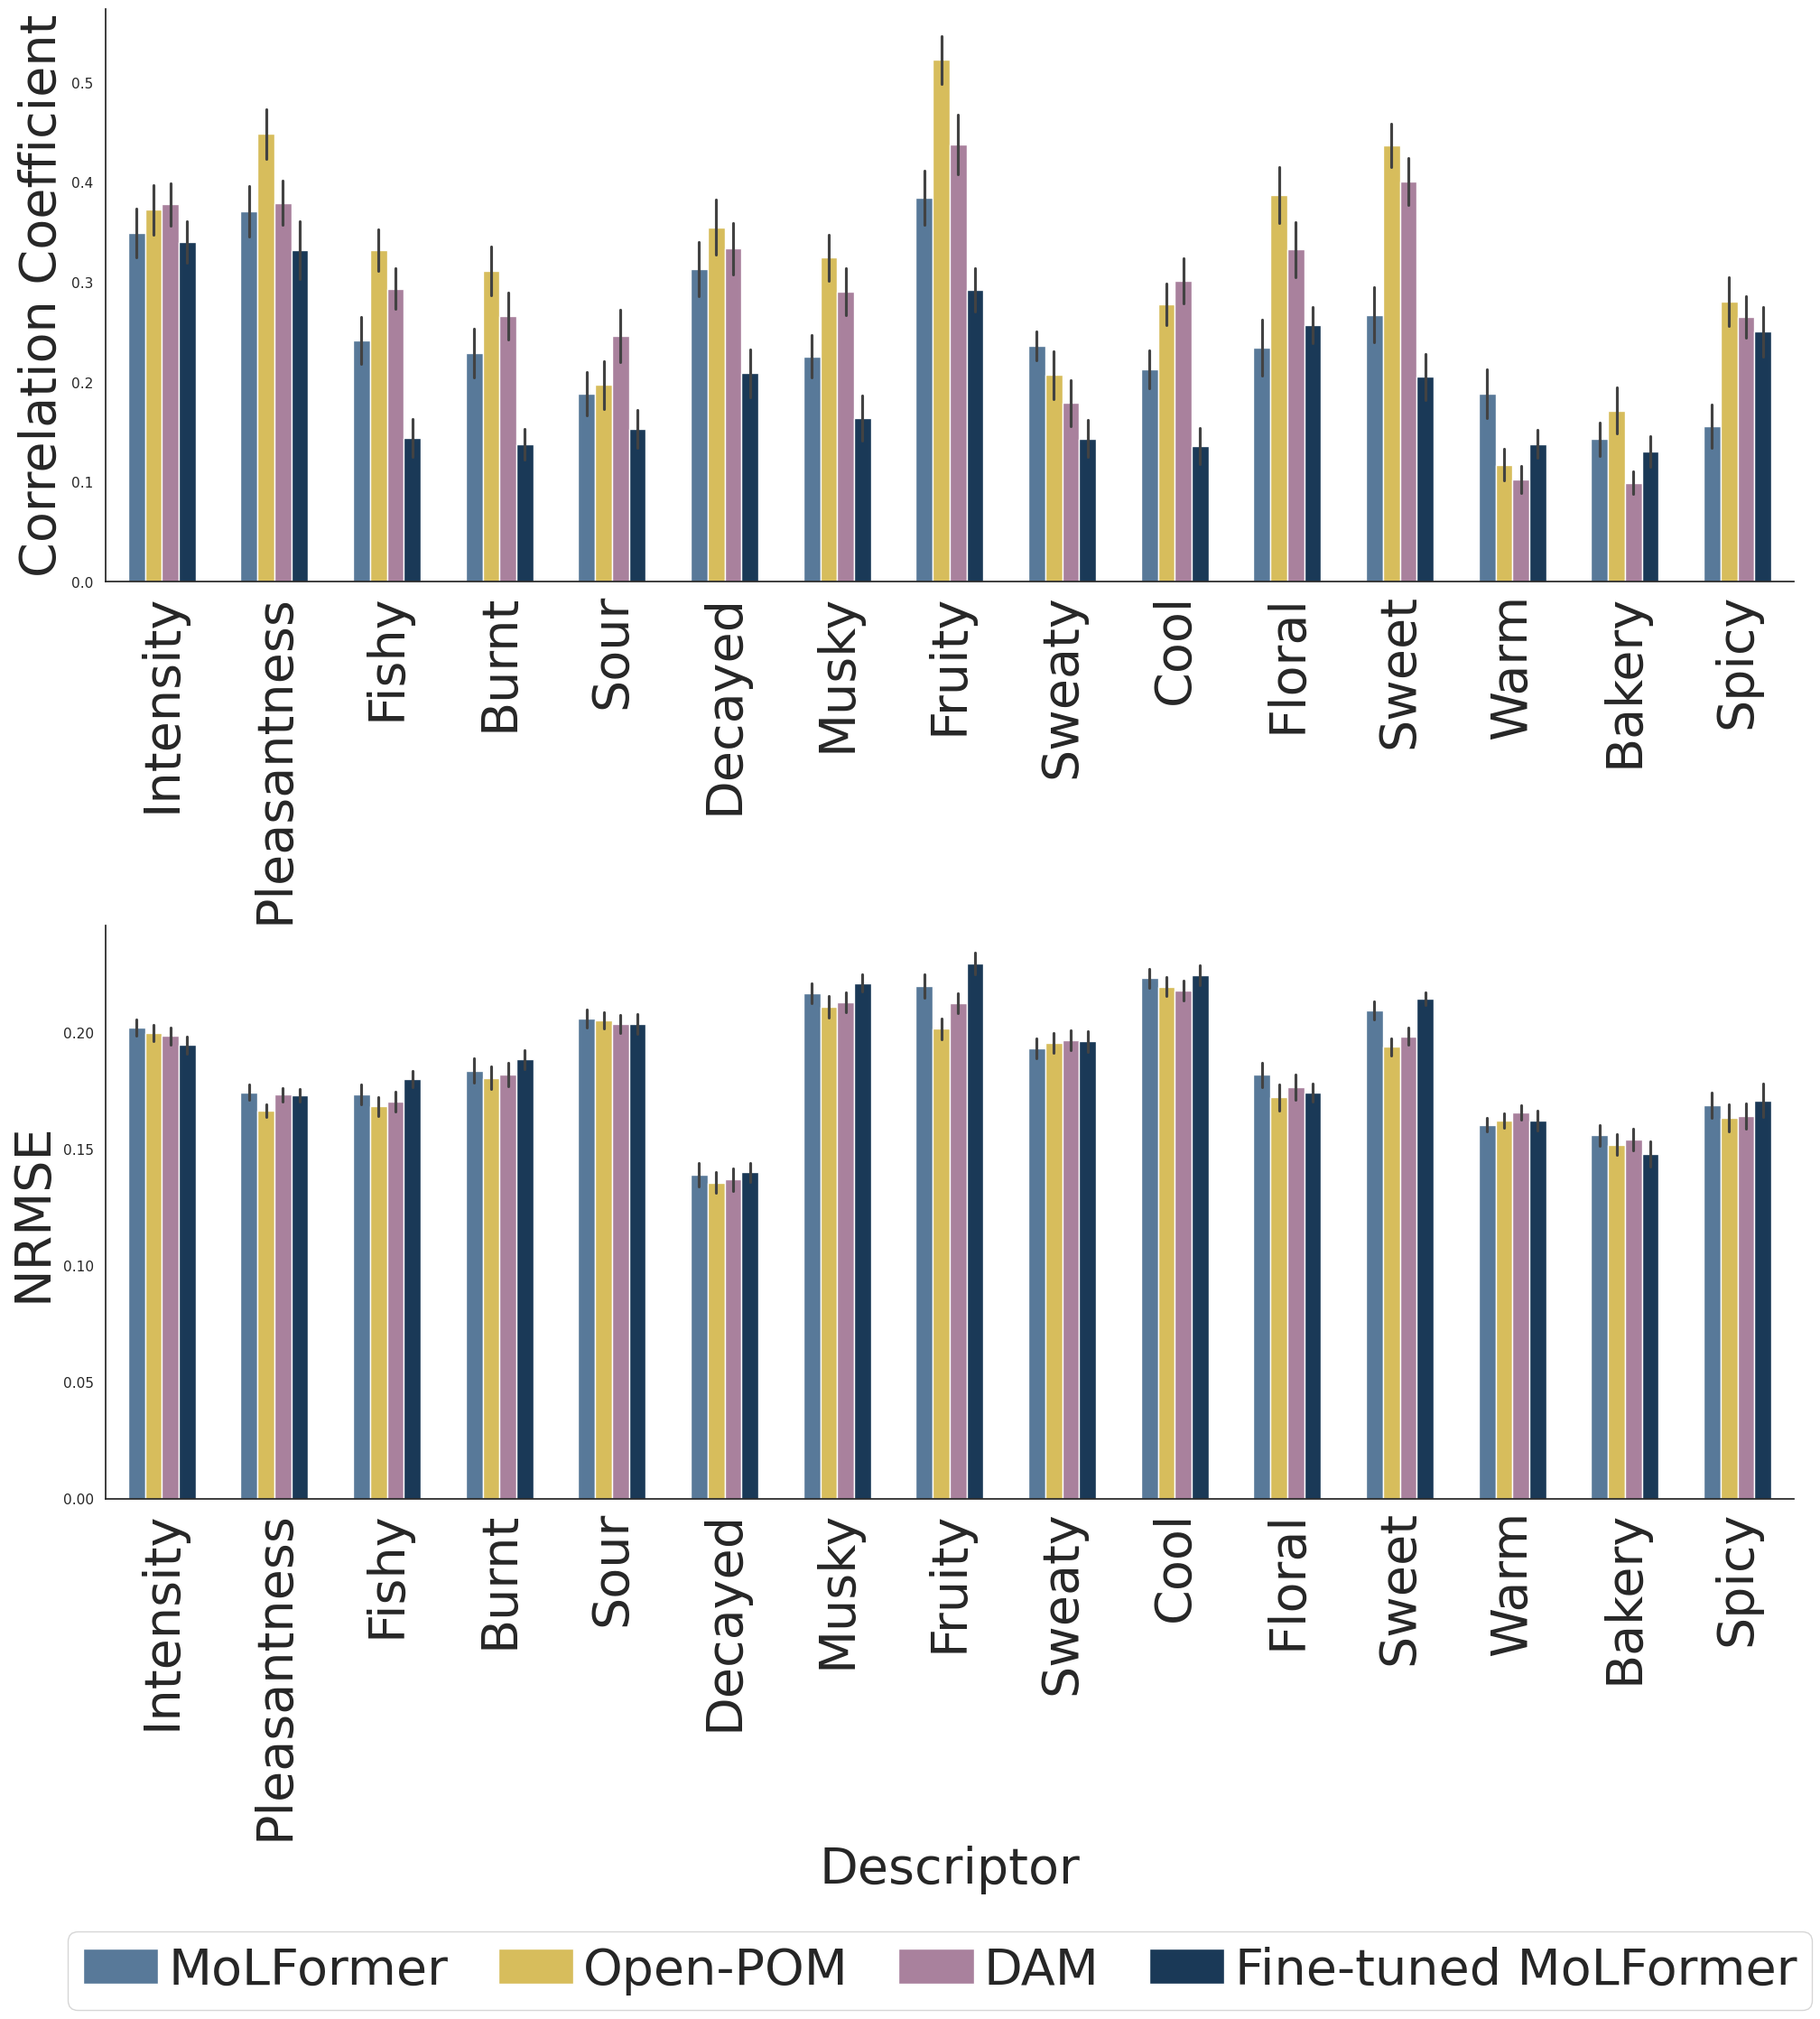

In [32]:
trend_learning_molformer_sagar = post_process_dataframe(df_sagar_corrs_molfomer,df_sagar_mses_molfomer,df_sagar_corrs_molfomerfinetuned,df_sagar_mses_molfomerfinetuned,df_sagar_cor_pom,df_sagar_cor_alva,df_sagar_mse_pom,df_sagar_mse_alva,sagar_tasks,"figs/sagar_regression")

In [33]:
df_concatenated_sagar = proccess_df_for_ICC("sagar_predictions.csv", ds='sagar',layer=13)
df_sagar_temp = df_sagar_temp.rename(columns={'subject': 'model', 'cid': 'CID'})
df_sagar_subjects = df_sagar_temp.melt(id_vars=['model', 'CID'], value_vars=sagar_tasks, var_name='variable', value_name='value')
df_sagar_subjects['model'] = df_sagar_subjects['model'].apply(lambda x: 'subject_' + str(x))
df_sagar_all = pd.concat([df_concatenated_sagar, df_sagar_subjects], axis=0)
model_list = ["subject_"+str(i) for i in range(1,4)]+['molformer','pom','alva']

In [34]:
df_results_sagar_all_antonio_faviorte = pd.DataFrame()
for model_1 in ['subjects_average']:
    df_results_sagar = compute_ICC_mvm_permolecul_avgsubj(df_sagar_all,model_list,model1=model_1)
    df_results_sagar['model_1'] = model_1
    df_results_sagar_all_antonio_faviorte = pd.concat([df_results_sagar_all_antonio_faviorte,df_results_sagar],axis=0)

Bakery     Type              Description       ICC         F  df1  df2          pval  \
0   ICC1   Single raters absolute  0.755423  7.177391  159  160  1.920602e-31   
1   ICC2     Single random raters  0.756219  7.374239  159  159  5.189012e-32   
2   ICC3      Single fixed raters  0.761172  7.374239  159  159  5.189012e-32   
3  ICC1k  Average raters absolute  0.860674  7.177391  159  160  1.920602e-31   
4  ICC2k    Average random raters  0.861190  7.374239  159  159  5.189012e-32   
5  ICC3k     Average fixed raters  0.864393  7.374239  159  159  5.189012e-32   

          CI95%  
0  [0.68, 0.81]  
1  [0.68, 0.82]  
2  [0.69, 0.82]  
3   [0.81, 0.9]  
4   [0.81, 0.9]  
5   [0.81, 0.9]  
Burnt     Type              Description       ICC         F  df1  df2          pval  \
0   ICC1   Single raters absolute  0.714222  5.998427  159  160  7.717015e-27   
1   ICC2     Single random raters  0.714297  6.009612  159  159  9.111456e-27   
2   ICC3      Single fixed raters  0.714678  6.009

ssssssmmmm [0, 0, 0]             model_1    model_2   variable       ICC
3  subjects_average  molformer  Intensity  0.123890
4  subjects_average        pom  Intensity  0.222159
5  subjects_average       alva  Intensity  0.164740
ssssssmmmm [1, 1, 1]              model_1    model_2      variable       ICC
9   subjects_average  molformer  Pleasantness  0.123664
10  subjects_average        pom  Pleasantness  0.159333
11  subjects_average       alva  Pleasantness  0.161260
ssssssmmmm [2, 2, 2]              model_1    model_2 variable       ICC
15  subjects_average  molformer    Fishy  0.078023
16  subjects_average        pom    Fishy  0.105807
17  subjects_average       alva    Fishy  0.020647
ssssssmmmm [3, 3, 3]              model_1    model_2 variable       ICC
21  subjects_average  molformer    Burnt  0.109047
22  subjects_average        pom    Burnt  0.158944
23  subjects_average       alva    Burnt  0.000784
ssssssmmmm [4, 4, 4]              model_1    model_2 variable       ICC
27  

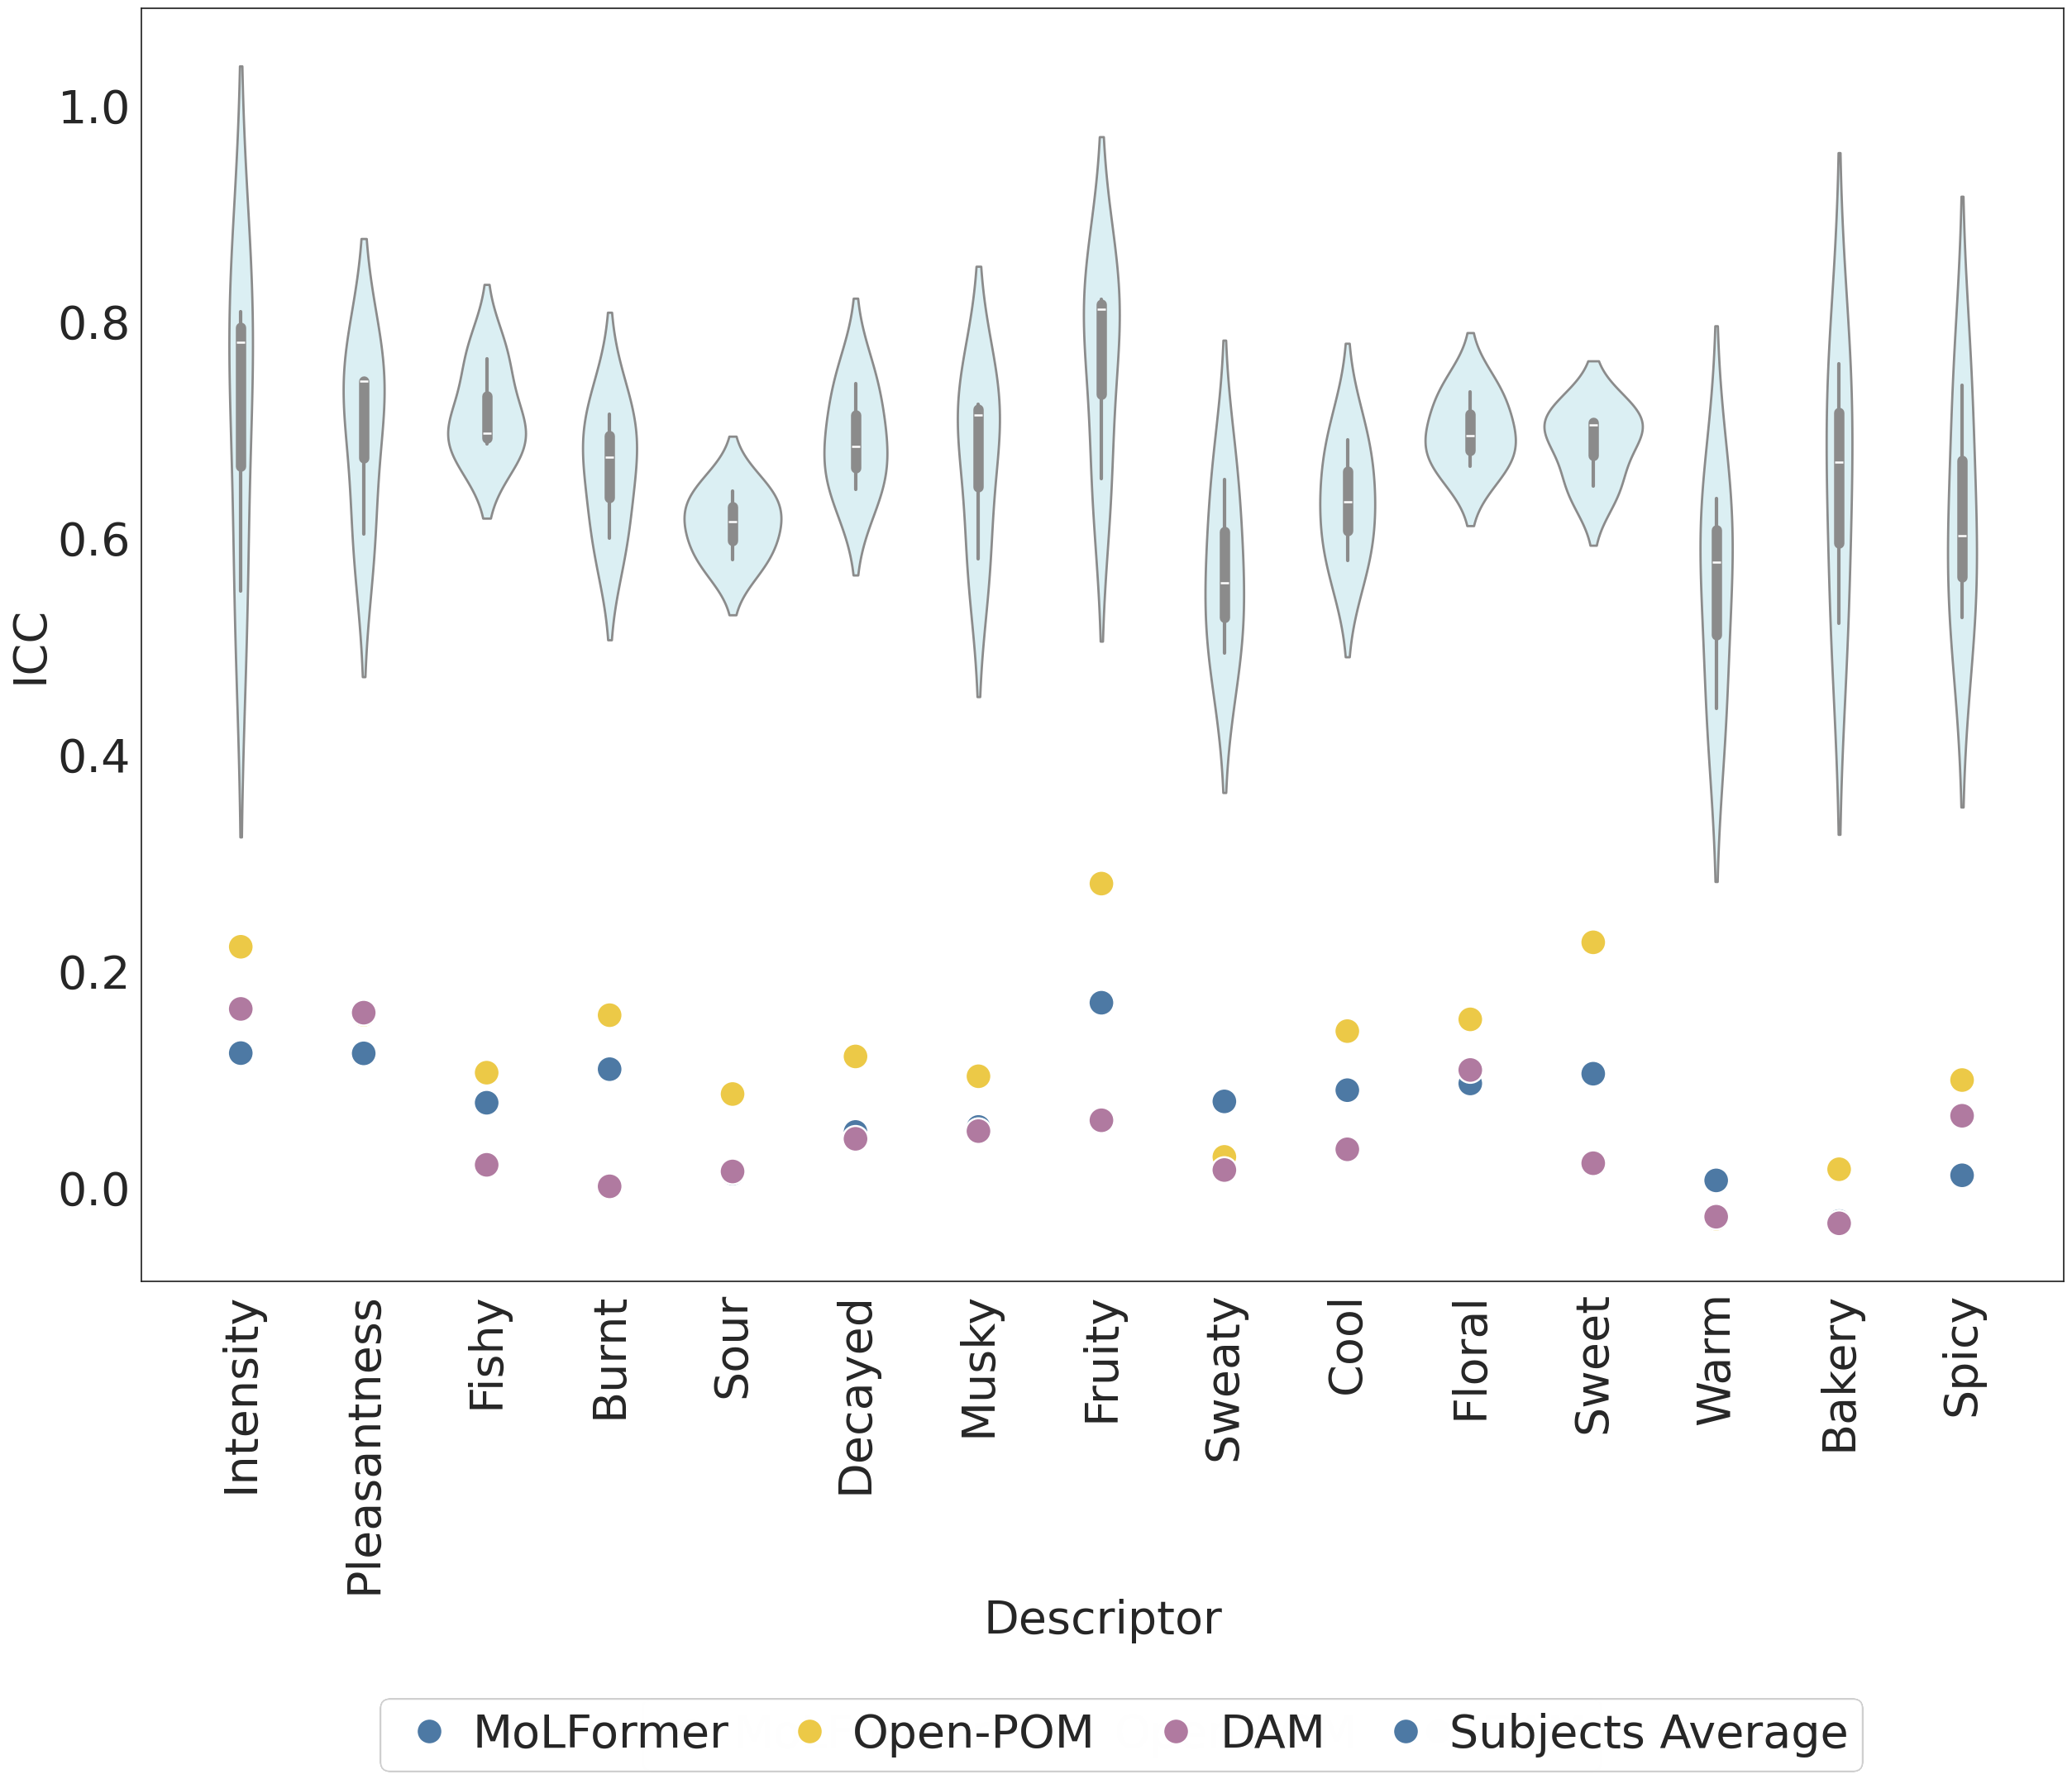

In [35]:
visualoze_violinplot(df_results_sagar_all_antonio_faviorte,ds='sagar',title='ICC')

In [24]:
# df_sagar=pd.read_csv(base_path+results_path+'sagar_predictions.csv')
# columns_predicted = [task+'_predicted' for task in sagar_tasks]
# columns_true= [task+'_true' for task in sagar_tasks]
# df_sagar_predictions = df_sagar[['model','CID']+columns_predicted]
# df_sagar_true = df_sagar[['model','CID']+columns_true]
# df_sagar_melted_predicted= pd.melt(df_sagar_predictions, id_vars=['model','CID'], value_vars=columns_predicted)
# df_sagar_melted_true = pd.melt(df_sagar_true, id_vars=['model','CID'], value_vars=columns_true)

In [25]:
# for cid in df_sagar_melted_predicted['CID'].unique():
#     df_sagar_melted_predicted[df_sagar_melted_predicted['CID']==cid]
# plot_miguel_favorite(df_sagar_melted_true,df_sagar_melted_predicted)

In [26]:
def plot_ICC_resutls(df,ds):
    if ds=='keller':
        tasks = keller_tasks
    elif ds=='sagar':
        tasks = sagar_tasks
    else:
        raise ValueError('Dataset not found')
    df_melted = df.melt(id_vars=['model_1', 'model_2'], value_vars=tasks, var_name='variable', value_name='ICC')
    
    # Create the scatter plot
    f = plt.figure(figsize=(35, 6))
    g = sns.scatterplot(data=df_melted, x='variable', y='ICC', hue='model_2', style='model_1',s=100,alpha=0.5)
    
    # Rotate x-axis labels for better visibility
    plt.xticks(rotation=90)
    handles, labels = g.get_legend_handles_labels()
    g.get_legend().remove()
    print("labels",labels)
    f.subplots_adjust(bottom=0.2, left=0.1, right=0.95, top=0.95)
    labels = ['','','','','','Model','MoLFormer', 'Open-POM', 'DAM']
    f.legend(handles[-3:], labels[-3:], ncol=3, columnspacing=1, prop={'size': 40}, handlelength=1.5, loc="lower center",
              borderpad=0.3,
              bbox_to_anchor=(0.52, -0.7),
              frameon=True, labelspacing=0.4, handletextpad=0.2, )
    # plt.legend(title='Smoker', loc='upper left',)
    plt.subplots_adjust(hspace=0.6)
    f.savefig("ICC_"+ds + ".pdf", bbox_inches='tight')
    # Show the plot
    plt.show()

In [27]:
df_results_sagar_subjects = df_results_sagar_all[df_results_sagar_all['model_2']!='subjects_average']
plot_ICC_resutls(df_results_sagar_subjects,'sagar')
df_results_sagar_subjects = df_results_sagar_subjects.drop('model_2',axis=1)
#compute average over all the subjects
df_results_sagar_subjects.groupby('model_1').mean()
# df_results_sagar_subjects.groupby('model_1').select_dtypes(include=[np.number]).mean()


NameError: name 'df_results_sagar_all' is not defined

In [ ]:
plot_ICC_resutls(df_results_keller_all,'keller')

In [ ]:
# f2, ax = plt.subplots(2, 1, figsize=(22, 22))
# g1 = combine_visualize((df_results_keller[df_results_keller['model']=='molformer'], df_results_keller[df_results_keller['model']=='pom'],
#                            df_results_keller[df_results_keller['model']=='alva']), keller_tasks, ax[0], 'ICC',
#                            figure_name='ICC',abs=True)
# 
# g2= combine_visualize((df_results_sagar[df_results_sagar['model']=='molformer'], df_results_sagar[df_results_sagar['model']=='pom'],
#                             df_results_sagar[df_results_sagar['model']=='alva']), sagar_tasks, ax[1], 'ICC',
#                             figure_name='ICC',abs=True)
# 
# vertical_plot_tweak(f2, 'ICC', g1, g2)


In [ ]:

grouped_predicted = df_concatenated.groupby('variable')
# Initialize an empty dictionary to store the results
kappa_scores = {}

# For each group in group_predicted, compute interclass_corr between 

for (var_predicted) in zip(df_concatenated):
    pg.intraclass_corr(data=var_predicted, targets='value', raters='model',
                         ratings='Scores')
    
    # pg.intraclass_corr()
    # kappa = cohen_kappa_score(group_predicted['value'], group_true['value'])
    # kappa_scores[var_predicted] = kappa

# Print the results
for variable, kappa in kappa_scores.items():
    print(f"Cohen's kappa for {variable}: {kappa}")




#inter-rater agreement for pair of molecules

In [ ]:
# we want to plot m plots which m is the number of molecules in the dataset. for eah molecule we have n boxplot which is n tasks. boxplot show the distribution over subjects and we show the prediction as a line in the boxplot. We average over all the runs available in ds results.


#plot a boxplot for the average over all the tasks per _predicted descriptor_ 

#define plot_boxplot function
#plot a boxplot for the average over all the tasks per _predicted descriptor_
# def plot_boxplot(df, tasks, dataset):
#     for i in range(len(df)):
#         plt.figure(figsize=(12, 6))
#         sns.boxplot(data=df.iloc[i], showfliers=False)
#         plt.title(f'{dataset} - {tasks[i]}')
#         plt.xlabel('Subjects')
#         plt.ylabel('Predicted Value')
#         plt.show()
#            
# plot_boxplot(df_keller_predictions,keller_tasks,"keller_regression")

In [ ]:
cohen_kappa_score(df_keller_predictions_lastlayer_notruedduplicate['LogP_true'],df_keller_predictions_lastlayer_notruedduplicate['LogP_predicted'])

 Sagar